In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import nltk
import numpy as np
import re
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
#import transformers

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Importing datasets

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#

# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1elNqcb5tW9snmf-xRfMK0AvLUfEcOhC1'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('news_summary.csv')
'''
file_id = '1rAKmHTbGPOeuREC7Olk5oNHjNrdFHKkz'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('news_summary_more.csv')
'''

"\nfile_id = '1rAKmHTbGPOeuREC7Olk5oNHjNrdFHKkz'\ndownloaded = drive.CreateFile({'id': file_id})\ndownloaded.GetContentFile('news_summary_more.csv')\n"

In [ ]:
data = pd.read_csv('news_summary.csv', encoding='latin-1') #check encodings types
#more_data = pd.read_csv('news_summary_more.csv', encoding='latin-1')

#Exploring the datasets

## news_summary dataset


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4514 entries, 0 to 4513
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   author     4514 non-null   object
 1   date       4514 non-null   object
 2   headlines  4514 non-null   object
 3   read_more  4514 non-null   object
 4   text       4514 non-null   object
 5   ctext      4396 non-null   object
dtypes: object(6)
memory usage: 211.7+ KB


Nan values is found in the complete text 

In [ ]:
data.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [ ]:
duplicateRows1 = data[data.duplicated(subset=['ctext'])]
print('complete text duplicates')
print(duplicateRows1)

complete text duplicates
                  author  ...                                              ctext
42          Chhavi Tyagi  ...  The Daman and Diu administration on Wednesday ...
190         Chhavi Tyagi  ...  Charges and counter charges flew in the Lok Sa...
231   Niharika Prabhakar  ...                                                NaN
286        Saloni Tandon  ...                                                NaN
368         Chhavi Tyagi  ...  Bihar chief minister Nitish Kumar comfortably ...
...                  ...  ...                                                ...
4381        Chhavi Tyagi  ...  Rounding off a day of hectic electioneering in...
4423      Mansha Mahajan  ...                                                NaN
4454     Abhishek Bansal  ...                                                NaN
4500      Mansha Mahajan  ...                                                NaN
4508        Tarun Khanna  ...                                                NaN

[1

In [ ]:
print(str(data[4283:4284]['text']))
print(str(data[4285:4286]['text']))

4283    Elections in Goa ended up in a hung Assembly, ...
Name: text, dtype: object
4285    Uttar Pradesh Chief Minister Akhilesh Yadav on...
Name: text, dtype: object


In [ ]:
X = selected_features['text'].values
Y = selected_features['headlines'].values
type(X)

numpy.ndarray

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2)
X_train.shape, X_test.shape

((3611,), (903,))

# Abstractive Models

## SEQ 2 SEQ



In [ ]:
from keras.preprocessing.sequence import pad_sequences

The preprocessing stange of the raw text will include the first step:
1. Removing new line or escape spaces and replacing them with a regular space
2. Using the contraction mapping dictionary below to expand the contractions in text
3. Removin s-apostrophe ''s' of ownership
4. Removing any non alphanumeric character with removing commas in numbers and keeping decimal dots.
5. Removing stop words


---
Our dataset has proven very clean with manual investigation that's why for summary data, the last three processing steps won't be used in order to get better results.
In addition to that a start and end tokens are added in case of summary
---


In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [ ]:
def preprocess_text(textset):
    '''
    This function applies necessary preprocessing in order to produce synsets for the similarity functions
    Inputs:
        sentences [array or list containing the sentences]
    Outputs:
        processed tokens
    '''
    stop_words = set(stopwords.words('english'))
    cleaned_text = []
    for text in textset: 
        # Replacine Irregular Spaces with regular ones 
        new_text=re.sub("(\\t)", ' ', text).lower()
        new_text=re.sub("(\\r)", ' ', new_text) 
        new_text=re.sub("(\\n)", ' ', new_text)
        # Contraction mapping
        new_text = ' '.join([contraction_mapping[word] if word in contraction_mapping.keys() else word for word in new_text.split()])
        # Removing 's
        new_text = re.sub(r"'s\b|s'\b","",new_text)
        # Removing any non alphanumeric character
        new_text = re.sub("[^a-zA-Z0-9\ ]", "", new_text)
        # Removing Stop words
        new_text = ' '.join([word for word in new_text.split() if word not in stop_words])
        
        cleaned_text.append(new_text)
    return cleaned_text


def preprocess_summary(summaryset):
    '''
    This function applies necessary preprocessing in order to produce synsets for the similarity functions
    Inputs:
        sentences [array or list containing the sentences]
    Outputs:
        processed tokens
    '''
    cleaned_summary = []
    for summary in summaryset: 
        # Replacine Irregular Spaces with regular ones 
        new_text=re.sub("(\\t)", ' ', summary).lower()
        new_text=re.sub("(\\r)", ' ', new_text) 
        new_text=re.sub("(\\n)", ' ', new_text)
        # Contraction mapping
        new_text = ' '.join([contraction_mapping[word] if word in contraction_mapping.keys() else word for word in new_text.split()])
        # Adding start and End token to signify beginning and end of summary
        new_text = 'ssss ' + new_text + ' aaaa'
        cleaned_summary.append(new_text)
    return cleaned_summary

In [ ]:
cleaned_text = preprocess_text(X_train)
cleaned_summary = preprocess_summary(y_train)
cleaned_text_test = preprocess_text(X_test)
cleaned_summary_test = preprocess_summary(y_test)

In [ ]:
for i in range(20):
    print('TEXT:\n' + cleaned_text[i] )
    print('HEADLINE:\n' + cleaned_summary[i] + '\n\n')

TEXT:
kerala police monday questioned congress mla anwar sadath cpim mlaactor mukesh connection malayalam actress abduction case anwar asked connections actor dileep arrested last week charges criminal conspiracy mukesh questioned police pulsar suni prime accused driver year
HEADLINE:
ssss police question 2 mlas in malayalam actress abduction case aaaa


TEXT:
pm narendra modi friday said indian side fired single bullet last 40 years border dispute china however acknowledged border dispute china responding question asking whether discord due china one belt one road obor project
HEADLINE:
ssss not a single bullet fired in 40 years on china: modi aaaa


TEXT:
human resource development minister prakash javadekar monday announced soon give approval 20 worldclass research teaching institutions called indian institutes eminence adding approval given parliament monsoon session said acclaimed ranked among top 200 universities world
HEADLINE:
ssss india to get 20 'institutes of eminence' for r

Using Keras Tokenizer to vectorize the data and generate our vocab

In [ ]:
## Tokenizing, vectorizing
text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(cleaned_text)
x_train_seq = text_tokenizer.texts_to_sequences(cleaned_text)
x_test_seq = text_tokenizer.texts_to_sequences(cleaned_text_test)

## Tokenizing, vectorizing
summary_tokenizer = Tokenizer()
summary_tokenizer.fit_on_texts(list(cleaned_summary))
y_train_seq = summary_tokenizer.texts_to_sequences(cleaned_summary)
y_test_seq = summary_tokenizer.texts_to_sequences(cleaned_summary_test)

Getting maximum length of train data text and summary to pad sequences according to them

In [ ]:
max_t_len = [len(text) for text in x_train_seq]
max_s_len =[len(summary) for summary in y_train_seq]
max_t_len.sort()
print("maximum text length is: {}\nmaximum summary length is: {}".format(max(max_t_len),max(max_s_len)))

maximum text length is: 47
maximum summary length is: 17


(array([  51.,  789., 1856.,  830.,   85.]),
 array([ 7.,  9., 11., 13., 15., 17.]),
 <a list of 5 Patch objects>)

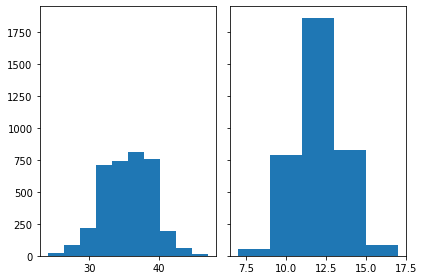

In [ ]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(max_t_len, bins=10)
axs[1].hist(max_s_len, bins=5)

In [ ]:
max_text_len = 47
max_summary_len = 16

In [ ]:
# Padding text and vocab generation
x_train_pad = pad_sequences(x_train_seq, maxlen=max_text_len, padding='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=max_text_len, padding='post')
text_vocab = len(text_tokenizer.word_index) + 1

# Padding summary and vocab generation
y_train_pad = pad_sequences(y_train_seq, maxlen=max_summary_len, padding='post')
y_test_pad = pad_sequences(y_test_seq, maxlen=max_summary_len, padding='post')
summary_vocab = len(summary_tokenizer.word_index) + 1

In [ ]:
for i in range(0,10):
    print('TEXT VECTOR:\n{}'.format(x_train_pad[i]) )
    print('HEADLINE VECTOR:\n{}\n\n',format(y_train_pad[i]))

TEXT VECTOR:
[  460     6    48  1065    42   447  7286 10274  3092 10275  3491   842
  1581    54  2273    58  7286    51  4696    28  2274    62    35   227
   405   927  2275  3491  1065     6  5662  4697   110    41   471    25
     0     0     0     0     0     0     0     0     0     0     0]
HEADLINE VECTOR:
{}

 [   1   39 1336   32  261    4  756  197  905   49    2    0    0    0
    0    0]
TEXT VECTOR:
[   66    72    29    57     1    11   605  1492   778  2756    35   928
    27   280  2502   100    70  4698   280  2502   100  1402  1019   415
   472 10276    91   100    19  7287    19   349 10277   371     0     0
     0     0     0     0     0     0     0     0     0     0     0]
HEADLINE VECTOR:
{}

 [   1    9   12  757 1337  652    4  504   82    7   72   34    2    0
    0    0]
TEXT VECTOR:
[  461  5663   416     9  1925  2276    48    92   525   274  1194   248
  4699  1020  3492  2277    96    11  4700 10278   293  1194   153   426
  2503   809     1 10279  1403 

In [ ]:
x_train,Y_train= (np.array(x_train_pad),np.array(y_train_pad))

#### The Creation of the model

In [ ]:
latent_dim = 300
embedding_dim= 200

In [ ]:
# Encoder
encoder_inputs = Input(shape=(max_text_len,), name = 'encoder_imputs')

#embedding layer
enc_emb =  Embedding(text_vocab, embedding_dim,trainable=True, name = 'enc_emb')(encoder_inputs)

### 2 LSTM layers for encode

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4, name = 'encoder_lstm1')
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4, name= 'encoder_lstm2')
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4, name= 'encoder_lstm3')
encoder_output, state_h, state_c= encoder_lstm3(encoder_output2)

### Decoder

# using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,), name= 'decoder_inputs')

#embedding layer
dec_emb_layer = Embedding(summary_vocab, embedding_dim,trainable=True, name= 'dec_emb_layer')
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2, name='decoder_lstm')
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(summary_vocab, activation='softmax'), name= 'decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_imputs (InputLayer)     [(None, 47)]         0                                            
__________________________________________________________________________________________________
enc_emb (Embedding)             (None, 47, 200)      3842800     encoder_imputs[0][0]             
__________________________________________________________________________________________________
encoder_lstm1 (LSTM)            [(None, 47, 300), (N 601200      enc_emb[0][0]                    
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
______________________________________________________________________________________________

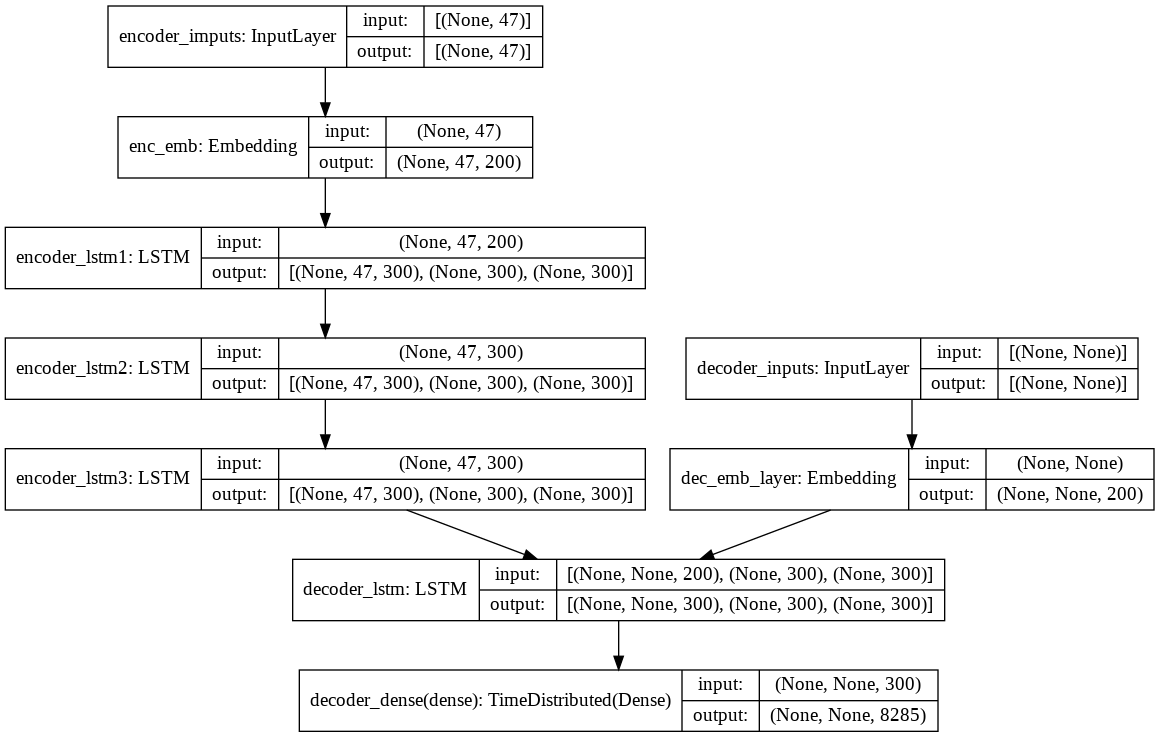

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [ ]:
lr = 0.001
model.compile(optimizer = Adam(learning_rate = lr), loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)

In [ ]:
history=model.fit([x_train,Y_train[:,:-1]], Y_train.reshape(Y_train.shape[0],Y_train.shape[1], 1)[:,1:] ,epochs=10,batch_size=20)

Epoch 1/10
181/181 [==============================] - 112s 576ms/step - loss: 3.4748
Epoch 2/10
181/181 [==============================] - 104s 577ms/step - loss: 3.1785
Epoch 3/10
181/181 [==============================] - 105s 578ms/step - loss: 2.9871
Epoch 4/10
181/181 [==============================] - 104s 574ms/step - loss: 2.8125
Epoch 5/10
181/181 [==============================] - 103s 569ms/step - loss: 2.6569
Epoch 6/10
181/181 [==============================] - 103s 570ms/step - loss: 2.5095
Epoch 7/10
181/181 [==============================] - 105s 579ms/step - loss: 2.3755
Epoch 8/10
181/181 [==============================] - 103s 570ms/step - loss: 2.2572
Epoch 9/10
181/181 [==============================] - 103s 571ms/step - loss: 2.1518
Epoch 10/10
181/181 [==============================] - 103s 571ms/step - loss: 2.0497


In [ ]:
history=model.fit([x_train,Y_train[:,:-1]], Y_train.reshape(Y_train.shape[0],Y_train.shape[1], 1)[:,1:] ,epochs=10,batch_size=64)

Epoch 1/10
57/57 [==============================] - 36s 626ms/step - loss: 1.2192
Epoch 2/10
57/57 [==============================] - 36s 627ms/step - loss: 1.1950
Epoch 3/10
57/57 [==============================] - 36s 629ms/step - loss: 1.1708
Epoch 4/10
57/57 [==============================] - 36s 625ms/step - loss: 1.1562
Epoch 5/10
57/57 [==============================] - 36s 631ms/step - loss: 1.1405
Epoch 6/10
57/57 [==============================] - 36s 624ms/step - loss: 1.1245
Epoch 7/10
57/57 [==============================] - 36s 624ms/step - loss: 1.1109
Epoch 8/10
57/57 [==============================] - 35s 620ms/step - loss: 1.0982
Epoch 9/10
57/57 [==============================] - 36s 624ms/step - loss: 1.0837
Epoch 10/10
57/57 [==============================] - 35s 619ms/step - loss: 1.0703


In [ ]:
history=model.fit([x_train,Y_train[:,:-1]], Y_train.reshape(Y_train.shape[0],Y_train.shape[1], 1)[:,1:] ,epochs=10,batch_size=20)

Epoch 1/10
181/181 [==============================] - 104s 574ms/step - loss: 1.1351
Epoch 2/10
181/181 [==============================] - 104s 573ms/step - loss: 1.1132
Epoch 3/10
181/181 [==============================] - 103s 569ms/step - loss: 1.0753
Epoch 4/10
181/181 [==============================] - 103s 568ms/step - loss: 1.0364
Epoch 5/10
181/181 [==============================] - 104s 572ms/step - loss: 1.0041
Epoch 6/10
181/181 [==============================] - 103s 570ms/step - loss: 0.9749
Epoch 7/10
181/181 [==============================] - 104s 577ms/step - loss: 0.9456
Epoch 8/10
181/181 [==============================] - 105s 578ms/step - loss: 0.9164
Epoch 9/10
181/181 [==============================] - 104s 575ms/step - loss: 0.8921
Epoch 10/10
181/181 [==============================] - 104s 574ms/step - loss: 0.8631


In [ ]:
EPOCHS = 40
history=model.fit([x_train,Y_train[:,:-1]], Y_train.reshape(Y_train.shape[0],Y_train.shape[1], 1)[:,1:] ,
                  epochs=EPOCHS,batch_size=128, validation_data=([x_valid,Y_valid[:,:-1]],
                  Y_valid.reshape(Y_valid.shape[0],Y_valid.shape[1], 1)[:,1:]))

Epoch 1/40
23/23 [==============================] - 16s 684ms/step - loss: 2.6085 - val_loss: 5.9697
Epoch 2/40
23/23 [==============================] - 16s 679ms/step - loss: 2.5742 - val_loss: 5.9743
Epoch 3/40
23/23 [==============================] - 16s 687ms/step - loss: 2.5427 - val_loss: 5.9920
Epoch 4/40
23/23 [==============================] - 16s 682ms/step - loss: 2.5087 - val_loss: 6.0013
Epoch 5/40
23/23 [==============================] - 16s 685ms/step - loss: 2.4755 - val_loss: 6.0096
Epoch 6/40
23/23 [==============================] - 15s 666ms/step - loss: 2.4447 - val_loss: 6.0212
Epoch 7/40
23/23 [==============================] - 16s 681ms/step - loss: 2.4108 - val_loss: 6.0328
Epoch 8/40
23/23 [==============================] - 16s 690ms/step - loss: 2.3790 - val_loss: 6.0437
Epoch 9/40
23/23 [==============================] - 16s 690ms/step - loss: 2.3509 - val_loss: 6.0507
Epoch 10/40
23/23 [==============================] - 16s 676ms/step - loss: 2.3193 - val_lo

In [ ]:
EPOCHS = 70
history=model.fit([x_train,Y_train[:,:-1]], Y_train.reshape(Y_train.shape[0],Y_train.shape[1], 1)[:,1:] ,
                  epochs=EPOCHS,batch_size=128, validation_data=([x_valid,Y_valid[:,:-1]],
                  Y_valid.reshape(Y_valid.shape[0],Y_valid.shape[1], 1)[:,1:]))

Epoch 1/70
23/23 [==============================] - 16s 682ms/step - loss: 1.2451 - val_loss: 6.4856
Epoch 2/70
23/23 [==============================] - 16s 682ms/step - loss: 1.2317 - val_loss: 6.4891
Epoch 3/70
23/23 [==============================] - 15s 673ms/step - loss: 1.2175 - val_loss: 6.4963
Epoch 4/70
23/23 [==============================] - 16s 677ms/step - loss: 1.2074 - val_loss: 6.5044
Epoch 5/70
23/23 [==============================] - 16s 682ms/step - loss: 1.1949 - val_loss: 6.5155
Epoch 6/70
23/23 [==============================] - 16s 679ms/step - loss: 1.1815 - val_loss: 6.5194
Epoch 7/70
23/23 [==============================] - 15s 674ms/step - loss: 1.1684 - val_loss: 6.5233
Epoch 8/70
23/23 [==============================] - 15s 671ms/step - loss: 1.1589 - val_loss: 6.5316
Epoch 9/70
23/23 [==============================] - 15s 668ms/step - loss: 1.1457 - val_loss: 6.5335
Epoch 10/70
23/23 [==============================] - 15s 670ms/step - loss: 1.1327 - val_lo

In [ ]:
model.save('first_model.h5')

#Inference Models

 build the **Encoder inference model** to <br>
- Encode the input sequence 
- Get the decoder initial states

In [ ]:
encoder_model = Model(inputs = encoder_inputs, outputs = [encoder_output,state_h,state_c])
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_imputs (InputLayer)  [(None, 47)]              0         
_________________________________________________________________
enc_emb (Embedding)          (None, 47, 200)           3842800   
_________________________________________________________________
encoder_lstm1 (LSTM)         [(None, 47, 300), (None,  601200    
_________________________________________________________________
encoder_lstm2 (LSTM)         [(None, 47, 300), (None,  721200    
_________________________________________________________________
encoder_lstm3 (LSTM)         [(None, 47, 300), (None,  721200    
Total params: 5,886,400
Trainable params: 5,886,400
Non-trainable params: 0
_________________________________________________________________


**Decoder inference model**

In [ ]:
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))
#decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
embedded_decoder_inputs = dec_emb_layer(decoder_inputs)
decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(
    embedded_decoder_inputs , initial_state=[decoder_state_input_h,decoder_state_input_c])
decoder_outputs2 = decoder_dense(decoder_outputs) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [ decoder_state_h, decoder_state_c])


# Summarization functions

Use the generated toxenizer to get three dictionaries:
1. summary_index_dict a dictionary containing the indices keys of summary words and those words as values 
2. text_index_dict a dictionary containing the indices keys of text words and those words as values
3. summary_word_index a dictionary that has summary words as keys and their indices as values

In [ ]:
summary_index_dict =summary_tokenizer.index_word
text_index_dice =text_tokenizer.index_word
summary_word_index=summary_tokenizer.word_index

In [ ]:
def summarize(input_seq):
    '''
    This function produces summary sequences with the inference models generated from the trained model
    Input:
        It takes the input sequence to be summarized
    Output:
        It yields the summary sequence

    '''
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    summary_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    summary_seq[0, 0] = summary_word_index['ssss']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        # Decoding using the states from the encoder and the decoder output fro the last instance
        output_tokens, h, c = decoder_model.predict([summary_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        #print(sampled_token_index)

        # get the word of the output token
        sampled_token = summary_index_dict[sampled_token_index]
        
        # Check if its the end token
        if(sampled_token!= 'aaaa'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'aaaa'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        summary_seq = np.zeros((1,1))
        summary_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c
    
    #print(len(output_tokens[0,-1,:]))        
    return decoded_sentence

In [ ]:
for i in range(60,80):
  print("\n Predicted summary:",summarize(x_test_pad[i].reshape(1,max_text_len)))
  print(X_test[i])


 Predicted summary:  i am blessed that you even know i exist ranveer to amitabh
Actress Bipasha Basu has shared pictures of her performing various yoga asanas with her husband Karan Singh Grover on the occasion of International Yoga Day on Wednesday. Bipasha captioned one of the pictures, "Yoga is like Life - It's a beautiful balance of holding on & letting go." She also used the hashtag '#yogimonkey' while sharing the three pictures.

 Predicted summary:  delhi metro to launch housing scheme with 2bhk 3bhk flats
A painting which went missing from Air India's archives, was recently delivered to the airline's head office via post. The package did not mention the sender's name and had the painting made by Jatin Das for Air India, in a rolled up and damaged condition. The address registered by the sender was found to be a fake one in Gurugram. 

 Predicted summary:  delhi metro to get swipe machines for online transactions
The Railways is planning to purchase recycled water from private 

In [ ]:
for i in range(60,80):
  print("\n Predicted summary:",summarize(x_train[i].reshape(1,max_text_len)))
  #print(x_train[i])
  print([ text_index_dice[X] for X in x_train[i] if X != 0]) 
  print([ summary_index_dict[X] for X in Y_train[i] if X != 0]) 


 Predicted summary:  i am blessed that you even know i exist ranveer to amitabh
['none', 'mobile', 'payment', 'apps', 'digital', 'wallets', 'country', 'fully', 'secure', 'mobile', 'technologies', 'leader', 'qualcomm', 'claimed', 'apps', 'actually', 'run', 'completely', 'android', 'mode', 'hardware', 'level', 'security', 'turn', 'used', 'compromise', 'users', 'password', 'fingerprint', 'said', 'qualcomm']
['ssss', 'none', 'of', 'mobile', 'payment', 'apps', 'in', 'india', 'fully', 'secure', 'qualcomm', 'aaaa']

 Predicted summary:  delhi metro to get swipe machines for online transactions
['central', 'board', 'film', 'certification', 'cbfc', 'reissue', 'film', 'certificate', 'jolly', 'llb', '2', 'following', 'bombay', 'high', 'court', 'order', 'delete', 'four', 'scenes', 'film', 'one', 'scenes', 'shows', 'shoe', 'hurled', 'film', 'producers', 'reportedly', 'approach', 'supreme', 'court', 'film', 'due', 'release', 'february', '10']
['ssss', 'cbfc', 'to', 'reissue', 'certificate', 'to', '

## Results from testing on a larger dataset

In [ ]:
for i in range(60,80):
  print("\n Predicted summary:",summarize(x_test_pad[i].reshape(1,max_text_len)))
  print(X_test[i])


 Predicted summary:  india s first lingerie vending machine to be brought down
The Kerala government on Tuesday said the state's tourism sector registered a loss of about ?1,000 crore post the demonetisation drive by the Centre. The number of foreign tourists visiting the state decreased by 10-15% while the number of domestic tourists dipped by 20-30%. The fall is in contrast to the increase in the numbers before demonetisation, the government added. 

 Predicted summary:  i am not a feminist i am a feminist i am scared karan johar
A TV channel journalist who was reporting the shortfall of audience at Congress' Jan Aakrosh Rally by showing empty seats at the venue on Sunday was allegedly heckled by some party supporters. Delhi BJP Spokesperson Praveen S Kapoor tweeted a purported video of the incident, asking Congress leaders including Delhi Congress President Ajay Maken to apologise to the journalist.

 Predicted summary:  i am not a feminist i am a feminist i am scared karan johar
K

In [ ]:
for i in range(60,80):
  print("\n Predicted summary:",summarize(x_train[i].reshape(1,max_text_len)))
  #print(x_train[i])
  print([ text_index_dice[X] for X in x_train[i] if X != 0]) 


 Predicted summary:  us to classify data on syria chemical attacks russia
['technology', 'giant', 'google', 'extended', 'warranty', 'pixel', '2', 'pixel', '2', 'xl', 'smartphones', 'two', 'years', 'vp', 'product', 'management', 'mario', 'queiroz', 'announced', 'comes', 'users', 'reported', 'pixel', '2', 'xl', 'screens', 'turning', 'grey', 'suggesting', 'burnin', 'google', 'also', 'add', 'mode', 'saturated', 'colours', 'via', 'software', 'update', 'devices', 'tackle', 'issue']

 Predicted summary:  i am not a feminist i am a feminist i am scared karan johar
['minister', 'state', 'civil', 'aviation', 'jayant', 'sinha', 'tuesday', 'said', '285', 'theft', 'cases', 'reported', '13', 'airports', 'three', 'years', 'till', 'february', '2017', 'asserting', 'significant', 'increase', 'cases', 'sinha', 'said', 'six', 'theft', 'cases', 'reported', 'year', 'count', '64', '2016', '101', '2015', '114', '2014']

 Predicted summary:  i am not a feminist i am a feminist i am scared karan johar
['tesla'